In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
#import matplotlib.tri as tri

#from fem.element import Element
from fem import Element, Triangulation

In [2]:
def print_HTP(H, T, P, filename="output.txt"):
    """
    Print matrices to .txt-file (name of file = filename).
    H... overall assembled stiffness matrix
    T... nodal temperature vector
    P... nodal force vector

    Make sure, that your system of equations is sorted by
    ascending node numbers, i.e., N1 N2 ... N100.
    """

    F = open(filename, 'w')

    F.write("Stiffness matrix H: \n")
    for row in H:
        for col in row:
            outline = "{0:+8.4e},".format(col)
            F.write("{0:11s}".format(str(outline)))
        F.write("\n")

    F.write("Temperature T: \n")
    for row in T:
        for col in row:
            outline = "{0:+8.4e},".format(col)
            F.write("{0:11s} \n".format(str(outline)))


    F.write("Force vector P: \n")
    for row in P:
        for col in row:
            outline = "{0:+8.4e},".format(col)
            F.write("{0:11s} \n".format(str(outline)))

    F.close()

    return None

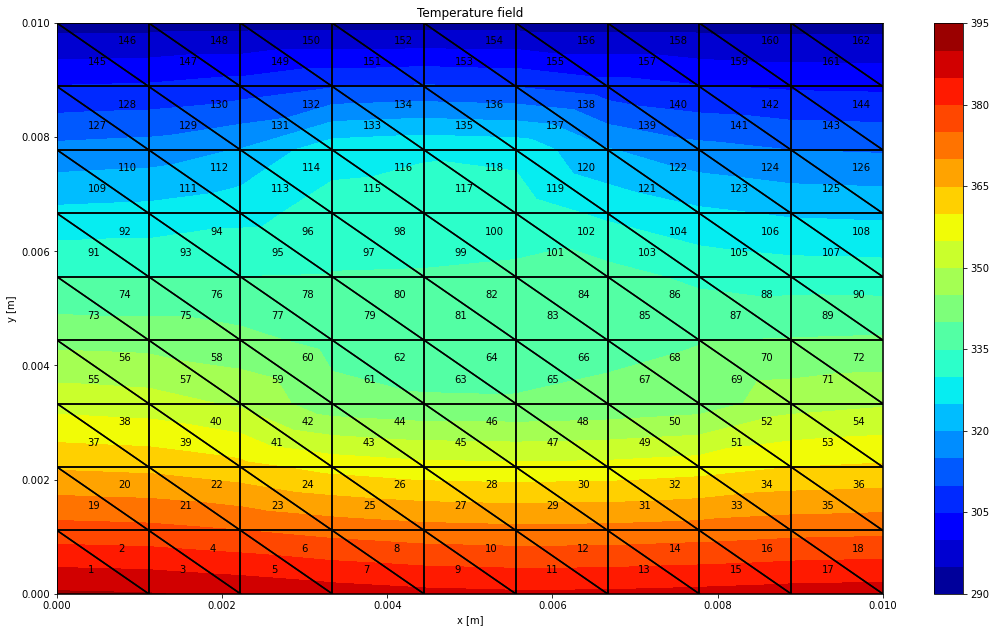

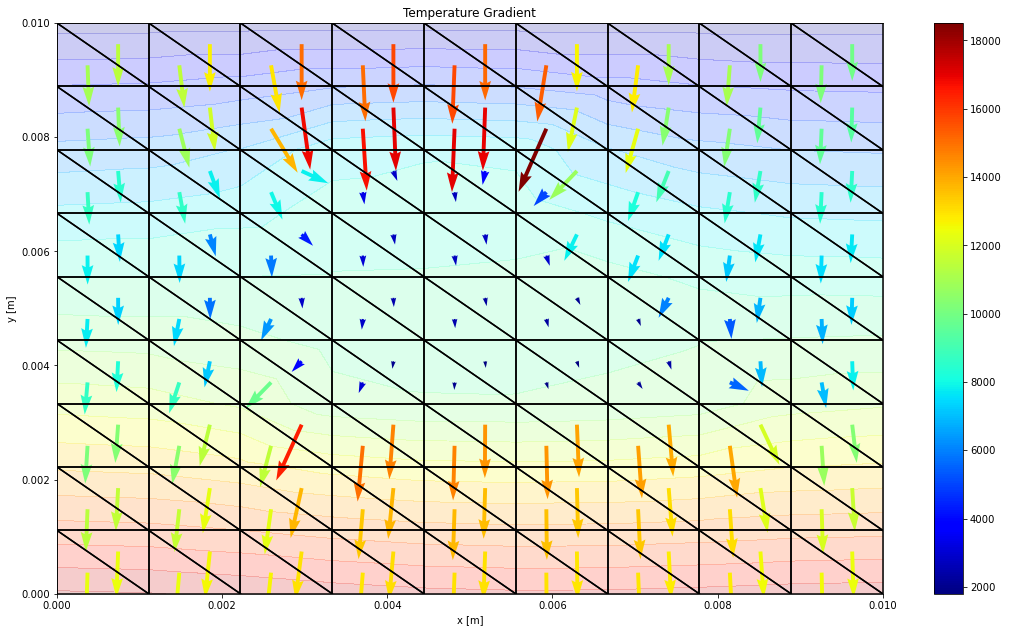

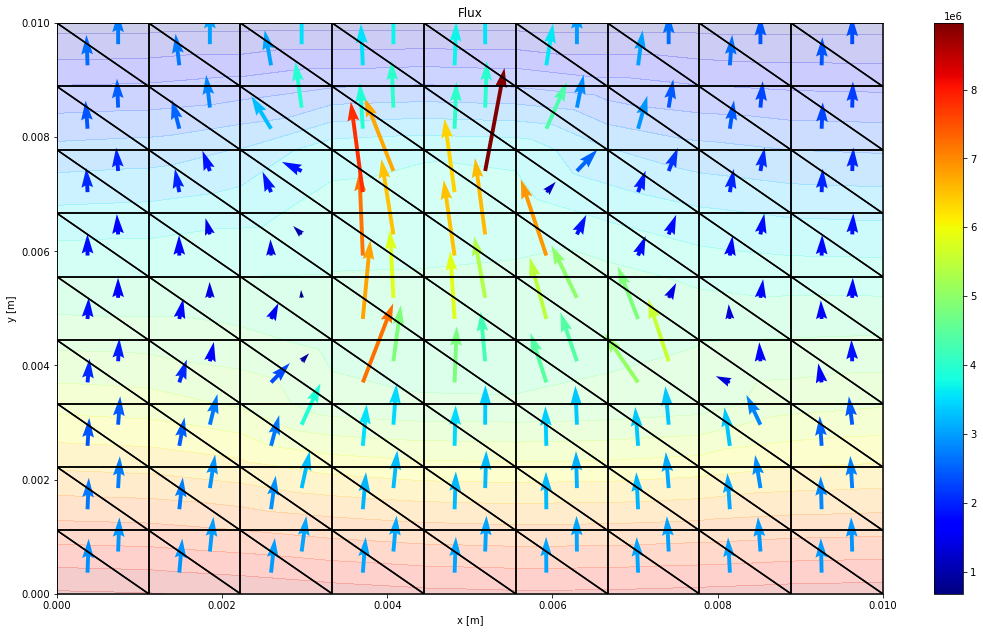

In [3]:
# Setup the simulation

# simulation parameters
L = 0.01  # [m]
hz = 0.001  # [m]
k = 236
n = 10  # number nodes in one direction (value can't be simply changed since the equation system is hardcoded)

# BCs
dirichletT = 293  # [K]
q = 3000000  # [W/m^2]

# Temperature vector
T = np.ones((n*n,1))*(-1)
for i in np.linspace(90,99,10,dtype=int):
    T[i] = dirichletT

# Load vector
P = np.zeros((n*n,1))
qPerArea = q*(L/(n-1)*hz)  # power one element sees
for i in range(10):
    P[i] = qPerArea
P[0] = qPerArea/2
P[9] = qPerArea/2

# about the parameters for Triangulation: (L... length of domain, n-1... how many elements in x and y direction
#                                          k... k, hz... element thickness, mode... 0=base mode / 1=trpezoidal 
#                                          2=bias / 4=different k, how much upper edge gets distorted in trapezoidal
#                                          can also be used for other modes, c... scale factor for k in mode 4)
Tri = Triangulation(L,n-1,n-1,k,hz,mode=4,factorV1=1,c=10)
mesh = Tri.createTriangulation()
H = mesh.assembleH()

# System of equations
T[0:90] = np.linalg.solve(H[0:90,0:90], P[0:90]-H[0:90,90:100].dot(T[90:100]))
P[90:100] = H[90:100,0:90].dot(T[0:90]) + H[90:100,90:100].dot(T[90:100])
mesh.storeT(T)

# plot contour
mesh.plotTemperatureField(numbers=True)

# plot gradient and flux
mesh.calculateTempGradient()
mesh.plotTemperatureGradient()
mesh.calculateFlux()
mesh.plotFlux()

print_HTP(H,T,P,'BaseVersion.txt')